# Spatio-temporal prediction of simulated fields with Deep Learining 

In this notebook we will introduce a methodology to perform interpolation of spatio-temporal datasets with deep learning models, capturing the spatial, temporal and spatio-temporal dependencies in data. We will test the method on a simulated dataset (previously developed in R).

In [ ]:
# Loading all the required libraries.
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import os
import warnings
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE
import tensorflow as tf
from tensorflow import keras

## Data preprocessing

To emulate realistic 2-dimensional spatial patterns, 20 Gaussian random fields with Gaussian kernel are simulated and noted $X_k(\mathbf{s}), k = 1, \dots , 20$.  
Time series $Y_k(t_j)$ of length $T = 1080$, for $k = 1, \dots , 20$, are generated using an order 1 autoregressive model.
Then, the simulated spatio-temporal dataset is obtained as a linear combination of the spatial random fields $X_k(\mathbf{s})$, where $Y_k(t_j)$ plays the role of the coefficients at time $t_j$, i.e.
\begin{equation}\label{toy}
Z(\mathbf{s}, t_j) = \sum_{k=1}^{20} X_k(\mathbf{s})Y_k(t_j) + \varepsilon.
\end{equation}
where $\varepsilon$ is a noise term generated from a Gaussian distribution having zero mean and standard deviation equal to the 10\% of the standard deviation of the noise-free field.

In [ ]:
spat_basis = pd.read_csv('SIM1_spatialbasis.txt', sep=' ')
time_coeff = pd.read_csv('SIM1_timecoeff.txt', index_col=0, sep=' ')

In [ ]:
timesteps = 1008 # We select here the number of timestamps we want to work with. Let's use as en example the first 41 days
spatial_samples = 7500

time_coeff = time_coeff.iloc[:timesteps,:]
samples = spat_basis.sample(n=spatial_samples, random_state=42)

coords = samples[['X', 'Y']]
basis = samples.iloc[:,-20:]
reconstructed = tf.transpose(tf.matmul(time_coeff.values, tf.transpose(basis.values)))
print(reconstructed)

tf.Tensor(
[[ 11.88354743  15.58903281  13.25091362 ...  -4.17561939  -8.35563755
   -4.88323901]
 [  2.9822921    4.37617393   6.96859399 ... -27.831455   -27.2501037
  -25.66151995]
 [  8.24918576  -0.08732369  -0.07817901 ...  12.58317924  19.34196623
   23.3460118 ]
 ...
 [ 10.98858491  10.38793036  12.29612036 ... -16.71502512 -16.32219665
  -20.49623252]
 [-15.71615759 -12.58694507  -2.71879878 ...  -4.94588169  -4.18735402
   -2.30608679]
 [  1.67504782  -2.43731162  -8.34990687 ...  38.96179238  42.21269396
   45.38798748]], shape=(7500, 1008), dtype=float64)


In [ ]:
field = tf.transpose(tf.matmul(time_coeff.values, tf.transpose(spat_basis.iloc[:,-20:].values)))
field_coords = spat_basis[['X', 'Y']]

#sigma_field = tf.math.reduce_std(field, 0) * percentage # variance of the error we will generate
#noise_field = tf.random.normal(field.shape,0,sigma_field, dtype=tf.float64)
sigma = (0.1*tf.math.reduce_std(field))
noise_field = tf.random.normal(field.shape,0,sigma, dtype=tf.float64)

field = field + noise_field

In [ ]:
#percentage = 0.2
#sigma = tf.math.reduce_std(reconstructed, 0) * percentage # variance of the error we will generate
noise = tf.random.normal(reconstructed.shape,0,sigma, dtype=tf.float64)
#noise = tf.random.normal(reconstructed.shape,0,(0.2*tf.math.reduce_std(reconstructed)), dtype=tf.float64)

reconstructed = reconstructed + noise
print(reconstructed)

tf.Tensor(
[[ 12.21114388  15.55241419  16.2765251  ...  -6.50892051 -10.52874926
   -6.03630377]
 [  2.34880063   0.76315781   6.60287124 ... -26.98358878 -25.2234041
  -24.31794562]
 [  8.16194192  -1.57720691   0.65235057 ...  12.25329067  20.3653031
   24.75440063]
 ...
 [ 11.32240657  10.70792363  14.71059882 ... -14.67204696 -20.11974558
  -18.14597413]
 [-17.32847704  -9.92170219  -1.33386164 ...  -5.23110247  -4.86753672
   -0.22783172]
 [  2.83885021  -3.64972514  -9.41736925 ...  38.86362019  44.46063132
   44.68099893]], shape=(7500, 1008), dtype=float64)


In [ ]:
np.var(noise_field)

2.399483463872344

In [ ]:
train_n = 3000 # we will later split into training and validation
test_n = 1000

X_train = coords.iloc[:train_n, :]
X_test = coords.iloc[train_n:train_n+test_n,:]
y_train = reconstructed[:train_n, :]
y_test = reconstructed[train_n:train_n+test_n,:]
print(y_train)

tf.Tensor(
[[ 12.21114388  15.55241419  16.2765251  ...  -6.50892051 -10.52874926
   -6.03630377]
 [  2.34880063   0.76315781   6.60287124 ... -26.98358878 -25.2234041
  -24.31794562]
 [  8.16194192  -1.57720691   0.65235057 ...  12.25329067  20.3653031
   24.75440063]
 ...
 [ -1.09299442  -1.97802491  -2.31465582 ...   5.34413257   4.97597015
    9.32226643]
 [ -9.76728699  -7.64206185  -6.39899911 ...  23.71739144  21.19115492
   24.75232226]
 [  0.73463824  -1.86545972  -2.69484128 ...   6.68378781   5.36483554
   10.24712187]], shape=(3000, 1008), dtype=float64)


In [ ]:
np.savetxt("Simulated_Xtest.txt", X_test, delimiter=",")
np.savetxt("Simulated_Xtrain.txt", X_train.iloc[:2000,:], delimiter=",")

np.savetxt("Simulated_Ytrain.txt", y_train, delimiter=",")

## SVD decomposition of training data

We want to decompose the training target values using a SVD (EOF).  In this way we will obtain three objcets: a set of principal component time series, a set of eigenvalues and a set of spatial coeffiecents. Moreover, we need to store the temporal mean of the raw data. As we will subtract this quantity before performing svd, we will need it later on to reconstruct the original signal.
The decomposition is done accoring to Wikle, 2019.

In [ ]:
Z = tf.cast(y_train, tf.float32) 
print('Matrix Z: \n{}\n'.format(Z))

time_mean = tf.reduce_mean(Z, 0)
nS = tf.constant(Z.shape[0], dtype =tf.float32)
time_mean = tf.reshape(tf.tile(time_mean, [nS]), [nS, time_mean.shape[0]])

Ztime_detrend = Z - time_mean
Ztilde = 1/tf.sqrt(nS-1)*Ztime_detrend
print('Matrix Ztiled: \n{}\n'.format(Ztilde))

# Using tf.linalg.svd to calculate the singular value decomposition 
s, u, v = tf.linalg.svd(Ztilde)
u =  u * tf.sqrt(nS-1)
print('Diagonal S: \n{} \n\nMatrix U: \n{} \n\nMatrix V^T: \n{}'.format(s, u, v))

Matrix Z: 
[[ 12.2111435   15.552414    16.276525   ...  -6.5089207  -10.528749
   -6.036304  ]
 [  2.3488007    0.7631578    6.6028714  ... -26.98359    -25.223404
  -24.317945  ]
 [  8.161942    -1.5772069    0.65235054 ...  12.253291    20.365303
   24.7544    ]
 ...
 [ -1.0929945   -1.978025    -2.3146558  ...   5.3441324    4.9759703
    9.322267  ]
 [ -9.767287    -7.6420617   -6.398999   ...  23.717392    21.191154
   24.752323  ]
 [  0.7346382   -1.8654597   -2.6948414  ...   6.683788     5.3648357
   10.247122  ]]

Matrix Ztiled: 
[[ 0.27816257  0.3392539   0.35650888 ... -0.19677189 -0.2708365
  -0.18346186]
 [ 0.09807162  0.06919524  0.17986347 ... -0.5706488  -0.5391677
  -0.5172931 ]
 [ 0.20422226  0.0264591   0.07120422 ...  0.14583477  0.29330316
   0.37879062]
 ...
 [ 0.03522284  0.01913998  0.01702531 ...  0.01967034  0.01228686
   0.09699275]
 [-0.12317374 -0.08428795 -0.05755669 ...  0.35517457  0.3083836
   0.3787527 ]
 [ 0.06859626  0.02119547  0.01008295 ...  0.04

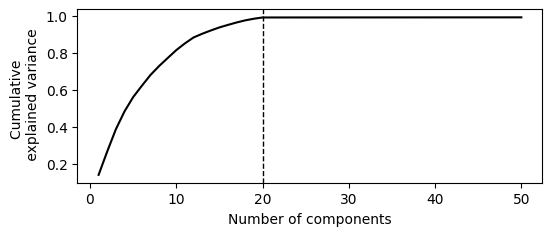

In [ ]:
plt.figure(figsize=(6,2.25))
plt.plot(np.arange(1, 51), (np.cumsum(tf.math.square(s)/tf.reduce_sum(tf.math.square(s))))[:50], c='black')
plt.axvline(20, color='black', linestyle='--', linewidth =1)
#plt.axvline(565, color='black', linestyle='--', linewidth =1)
#plt.title('Cumulative sum of explained varicane by component')
plt.ylabel('Cumulative \n explained variance')
plt.xlabel('Number of components')
plt.savefig('Simulated_screeplot_noise.pdf', dpi=300)

In [ ]:
(np.cumsum(tf.math.square(s)/tf.reduce_sum(tf.math.square(s))))[:25]

array([0.1429948 , 0.26898107, 0.3883193 , 0.48431242, 0.56118596,
       0.6216634 , 0.6799188 , 0.7282051 , 0.77147776, 0.81421524,
       0.8504779 , 0.88229364, 0.9022482 , 0.91994387, 0.93652123,
       0.9501371 , 0.96319115, 0.9745743 , 0.98331034, 0.9900163 ,
       0.9900412 , 0.990066  , 0.9900907 , 0.9901153 , 0.99013966],
      dtype=float32)

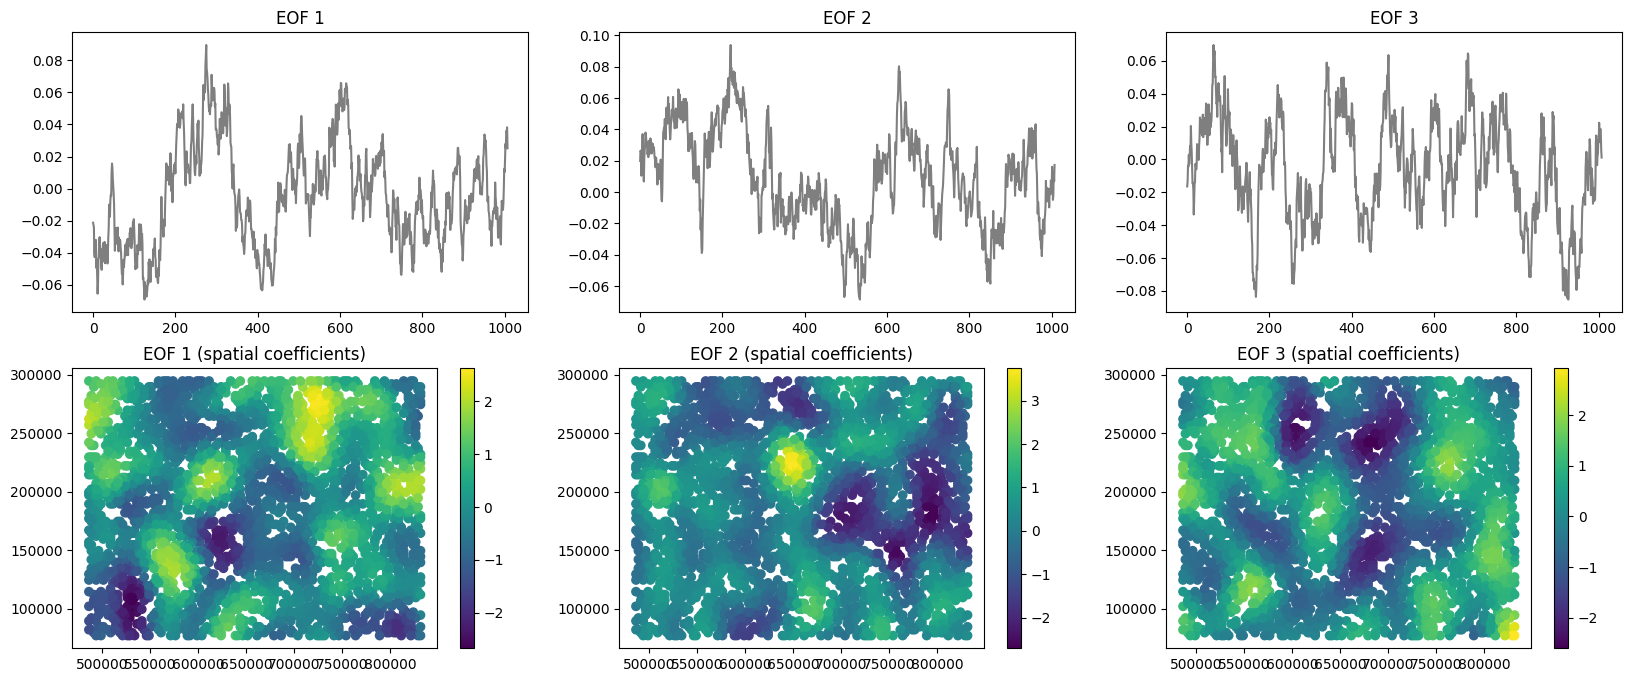

In [ ]:
plt.figure(figsize=(20,8))
plt.subplot(2,3,1)
plt.plot(np.arange(len(v[:,0])), v[:,0], color='black', alpha=0.5)
plt.title('EOF 1')
plt.subplot(2,3,2)
plt.plot(np.arange(len(v[:,1])), v[:,1], color='black', alpha=0.5)
plt.title('EOF 2')
plt.subplot(2,3,3)
plt.plot(np.arange(len(v[:,2])), v[:,2], color='black', alpha=0.5)
plt.title('EOF 3')


plt.subplot(2,3,4)
plt.scatter(X_train['X'], X_train['Y'],c=u[:,0])
plt.colorbar()
plt.title('EOF 1 (spatial coefficients)')
plt.subplot(2,3,5)
plt.scatter(X_train['X'], X_train['Y'],c=u[:,1])
plt.colorbar()
plt.title('EOF 2 (spatial coefficients)')
plt.subplot(2,3,6)
plt.scatter(X_train['X'], X_train['Y'],c=u[:,2])
plt.colorbar()
plt.title('EOF 3 (spatial coefficients)')
plt.savefig('Components_noise.pdf', dpi=300)

As expected, in absence of the noise term we can reconstruct the original signal using only 20 components. 
To verify this assumption, we can reconstruct the original signal with the first 20 EOFs and check if we obtain the same values of wind speed as in the origianl dataset.

In [ ]:
# To recompose 
n_eofs =19
tf_Z_approx = tf.matmul((u[:,:n_eofs]/tf.sqrt(nS-1)), tf.matmul(tf.linalg.diag(s[:n_eofs]), v[:,:n_eofs], adjoint_b=True))

print('Matrix Zt, reconstructed: \n{}\n'.format(tf_Z_approx))

reconstructed = tf_Z_approx * tf.sqrt(nS-1) + time_mean

check = reconstructed - Z
print('True - reconstructed data: \n{}\n'.format(check))

Matrix Zt, reconstructed: 
[[ 2.71757603e-01  3.39771420e-01  2.83708215e-01 ... -1.08981796e-01
  -1.87987551e-01 -1.31694213e-01]
 [ 1.06056288e-01  1.32465228e-01  1.64789468e-01 ... -5.44870317e-01
  -5.37668824e-01 -5.12288630e-01]
 [ 2.00608522e-01  5.64315915e-02  2.92101800e-02 ...  2.24003300e-01
   3.53147745e-01  4.16779786e-01]
 ...
 [ 4.67283204e-02  2.98459479e-03  5.84140755e-02 ...  5.62029183e-02
   3.97117026e-02  1.04921117e-01]
 [-1.22320734e-01 -3.68505530e-02  2.31894825e-04 ...  2.55929023e-01
   2.08707497e-01  2.51902133e-01]
 [ 4.59217690e-02  2.20339578e-02  2.82369647e-02 ...  6.82566166e-02
   3.14993933e-02  7.20014200e-02]]

True - reconstructed data: 
[[-0.3507557   0.02834129 -3.9867916  ...  4.8076596   4.5370665
   2.8349576 ]
 [ 0.43726563  3.4648619  -0.8255     ...  1.4117088   0.08208084
   0.2740593 ]
 [-0.19789982  1.6413872  -2.2997248  ...  4.280753    3.277275
   2.0804043 ]
 ...
 [ 0.6300757  -0.8847194   2.2665782  ...  2.000638    1.501870

## Modelling the coefficient maps and reconstruction of the full spatio-temporal field

We will model the coefficients using a deep feedforward fully connected neural network. 
$x$ and $y$ coordinates are used as inputs for a neural network having a first auxiliary output layer where the spatial coefficients are modelled. 
A recomposition layer will then use the $\tilde K$ modelled coefficients and the temporal bases $\phi_k$ resulting from the EOFs decomposition in order to reconstruct the final output -- i.e. the spatio-temporal field --.

The described network has multiple inputs, namely the spatial covariates -- which flow through the full stack of layers -- and the temporal bases directly connected to the output layer. It also has multiple outputs, namely the spatial coefficients for each basis, all modelled jointly, and the output signal. While the network is trained by minimizing the loss function on the final output, having as auxiliary output the spatial coefficients maps ensures a better explainability of the model, which is of primary importance in earth and climate sciences.

In [ ]:
train_val_split = 2000
n_eofs = 19
X_train, X_valid = X_train.values[:train_val_split,:], X_train.values[train_val_split:,:]
u_train, u_valid = u[:train_val_split,:n_eofs], u[train_val_split:,:n_eofs]
s = s[:n_eofs]
v = v[:,:n_eofs]
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_valid = scaler.transform(X_valid)
X_mesh = scaler.transform(field_coords)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


We now have to implement the neural netweork. We first define a custom recostruction layer. Then, we define a model using tensorflow functional functional API.

In [ ]:
def recompose(x):
    U = tf.cast(x, dtype=tf.float32)
    U = U/tf.sqrt(nS-1)
    test_mean = tf.reshape(time_mean[0,:], [1, time_mean[0,:].shape[0]])
    y_hat = (tf.matmul(U, tf.matmul(tf.linalg.diag(s), v, adjoint_b=True))) *  tf.sqrt(nS-1) + test_mean
    return y_hat

input_A = keras.layers.Input(shape=[2,]) # The input are the geographical variables X, Y, Z
batch1 = keras.layers.BatchNormalization()(input_A)
hidden_1 = keras.layers.Dense(300, activation="elu",
                              kernel_initializer="he_normal")(batch1)
batch2 = keras.layers.BatchNormalization()(hidden_1)
hidden_2 = keras.layers.Dense(100, activation="elu",
                              kernel_initializer="he_normal")(batch2)
batch3 = keras.layers.BatchNormalization()(hidden_2)
hidden_3 = keras.layers.Dense(100, activation="elu",
                              kernel_initializer="he_normal")(batch3)
batch4 = keras.layers.BatchNormalization()(hidden_3)
hidden_4 = keras.layers.Dense(100, activation="elu",
                              kernel_initializer="he_normal")(batch4)
batch5 = keras.layers.BatchNormalization()(hidden_4)
hidden_5 = keras.layers.Dense(100, activation="elu",
                              kernel_initializer="he_normal")(batch5)
batch6 = keras.layers.BatchNormalization()(hidden_5)
aux_output = keras.layers.Dense(n_eofs)(batch6)# Auxiliary output: spatial coefficients u
output = keras.layers.Lambda(recompose)(aux_output) # Main output: reconstructed y




K = keras.backend
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
            rate = max(rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)
batch_size = 32     
n_epochs = 200
patience = 20
onecycle = OneCycleScheduler(len(X_train) // batch_size * n_epochs, max_rate=0.005)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=patience, restore_best_weights = True) 

In [ ]:
def recompose(x):
    U = tf.cast(x, dtype=tf.float32)
    U = U/tf.sqrt(nS-1)
    test_mean = tf.reshape(time_mean[0,:], [1, time_mean[0,:].shape[0]])
    y_hat = (tf.matmul(U, tf.matmul(tf.linalg.diag(s), v, adjoint_b=True))) *  tf.sqrt(nS-1) + test_mean
    return y_hat

input_A = keras.layers.Input(shape=[2,]) # The input are the geographical variables X, Y, Z
hidden_1 = keras.layers.Dense(300, activation="elu",
                              kernel_initializer="he_normal")(input_A)
hidden_2 = keras.layers.Dense(100, activation="elu",
                              kernel_initializer="he_normal")(hidden_1)
hidden_3 = keras.layers.Dense(100, activation="elu",
                              kernel_initializer="he_normal")(hidden_2)
hidden_4 = keras.layers.Dense(100, activation="elu",
                              kernel_initializer="he_normal")(hidden_3)
hidden_5 = keras.layers.Dense(100, activation="elu",
                              kernel_initializer="he_normal")(hidden_4)
aux_output = keras.layers.Dense(n_eofs)(hidden_5)# Auxiliary output: spatial coefficients u
output = keras.layers.Lambda(recompose)(aux_output) # Main output: reconstructed y




K = keras.backend
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
            rate = max(rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)
batch_size = 32     
n_epochs = 2000
patience = 500
onecycle = OneCycleScheduler(len(X_train) // batch_size * n_epochs, max_rate=0.005)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=patience, restore_best_weights = True) 

Now we are ready to execute the model. When compiling it, we can also assign different weight to the error computed on the two different output layer. Here we will only compute the error on the final outpit layer.

In [ ]:
model = keras.Model(inputs=[input_A], outputs=[output, aux_output])
model.compile(loss=['mae', 'mae'], loss_weights=[1.0,0.0], optimizer='nadam')

history = model.fit([X_train], [y_train[:train_val_split,:], u_train], epochs=n_epochs,
                    validation_data=([X_valid], [y_train[train_val_split:,:], u_valid]),
                   callbacks=[early_stopping_cb, onecycle], verbose=0) 

y_hat_test, y_pred_test = model.predict([X_test])
y_hat_mesh, y_pred_mesh = model.predict([X_mesh])

KeyboardInterrupt: ignored

In [ ]:
mae = np.zeros(y_test.shape[1])
for i in range(y_test.shape[1]):
    mae[i] = MAE(y_test[:,i], y_hat_test[:,i])
    
mae_spatial =  np.zeros(y_test.shape[0])
for i in range(y_test.shape[0]):
    mae_spatial[i] = MAE(y_test[i,:], y_hat_test[i,:])
print(np.mean(mae_spatial))

NameError: name 'y_hat_test' is not defined

We can plot an examples of prediction map and time series are shown and compared with the true spatio-temporal field

NameError: name 'y_hat_mesh' is not defined

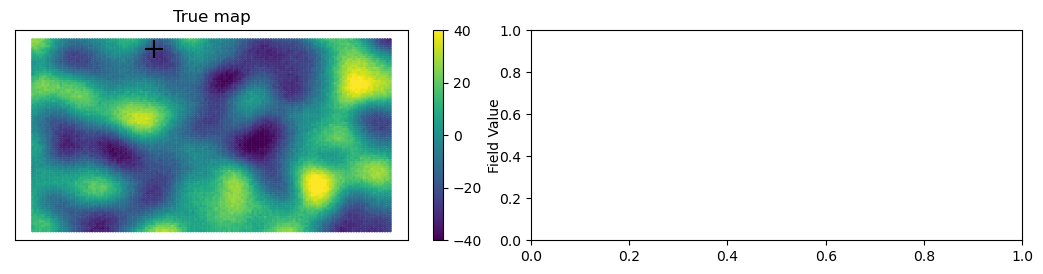

In [ ]:
seed = np.random.seed(seed=12345)
test_coords = coords.iloc[train_n:train_n+test_n,:]
loc = np.random.randint(0, test_coords.shape[0])
loc_x = test_coords['X'].iloc[loc]
loc_y = test_coords['Y'].iloc[loc]
timestamp = np.random.randint(0, mae.shape[0])

plt.figure(figsize=(13,6))
plt.subplots_adjust(wspace = 0.05)
plt.subplot(2,2,1)
plt.scatter(field_coords['X'], field_coords['Y'],c= field[:,timestamp], s = 2,  vmin=-40, vmax=40)
plt.xticks([], []); plt.yticks([], [])
plt.colorbar(label = 'Field Value')
plt.scatter(loc_x, loc_y, c ='black', marker='+', s=150)
plt.title('True map')
plt.subplot(2,2,2)
plt.scatter(field_coords['X'], field_coords['Y'],c= y_hat_mesh[:,timestamp], s = 2,  vmin=-40, vmax=40)
plt.xticks([], []); plt.yticks([], [])
plt.colorbar(label = 'Field Value')
plt.scatter(loc_x, loc_y, c ='black', marker='+', s=150)
plt.title('Predicted map')

plt.subplot(212)
plt.axvline(timestamp, color='black', linestyle='--', linewidth=1)
plt.plot(np.arange(1008), y_test[loc,:1008], label='True', color = 'black', linewidth = 0.8)
plt.plot(np.arange(1008), y_hat_test[loc,:1008], label='Predicted', color = 'orange', linewidth = 1.2)
plt.title('True versus predicted time series')
plt.ylabel('Field value')
plt.xlabel('$t$')
plt.legend()
plt.savefig('Simdata_predictions_noise_.pdf', dpi=300)

We can further investigate the smoothing effect vusually recognizable by comparing the minimum/maximum values in the training data with the ones in the training data.

In [ ]:
def control_stats(y_train, y_hat_mesh, time_mean, coords, s, v, nS, n_eofs):
    '''
    Function  to compute 'control stats' of the prediction maps.
    -------------------------------------------------------------
    Parameters: 
    - y_train: array-like of shape = [n_samples]
      The training output samples before EOF decomposition.
    - y_hat_mesh: dictionary-like 
      Dictionary resuling from the function ELM_executor.
    - time_mean: array-like of shape = [n_samples, timestamps]
      The temporal mean subtracted from data before performing the EOF decomposition
    - SwissMesh: array-like of shape = [n_samples, n_features]
      The prediction grid
    - s: array-like of shape = [n_EOF]
      The singular values resulting from the EOF decomposition
    - v: array-like of shape = [timesteps, n_samples]
      The principal components timeseries derived from the EOF decomposition
    - nS: array-like of shape = [n_trianing_samples]
      The previously computed number of training points
    - n_eofs: int or str, default = 'All'
      The number of EOF to be modelled. If all the EOFs have to be
      considered then set this parameter to 'All'; diversly, specify the
      number of EOFs.
    '''
    prediction_range =  y_test.shape[1]
    y_mean = np.zeros((1, prediction_range))
    y_var = np.zeros((1, prediction_range))
    y_min = np.zeros((1, prediction_range))
    y_max = np.zeros((1, prediction_range))
    mesh_mean = np.zeros((1, prediction_range))
    mesh_var = np.zeros((1, prediction_range))
    mesh_min = np.zeros((1, prediction_range))
    mesh_max = np.zeros((1, prediction_range))
    i = 0
    for t in range(0, prediction_range):
        y_mean[0, i] = np.mean(y_train[:, t])
        y_var[0, i] = np.var(y_train[:, t])
        y_min[0, i] = np.min(y_train[:, t])
        y_max[0, i] = np.max(y_train[:, t])        
        mesh_mean[0, i] = np.mean(y_hat_mesh[:, i])
        mesh_var[0, i] = np.var(y_hat_mesh[:, i])
        mesh_min[0, i] = np.min(y_hat_mesh[:, i])
        mesh_max[0, i] = np.max(y_hat_mesh[:, i])
        i += 1
    stats = pd.DataFrame({'y_mean':y_mean.ravel()[:,],'y_var':y_var.ravel()[:,],'y_min':y_min.ravel()[:,],'y_max':y_max.ravel()[:,],
                          'mesh_mean':mesh_mean.ravel()[:,],'mesh_var':mesh_var.ravel()[:,],'mesh_min':mesh_min.ravel()[:,],'mesh_max':mesh_max.ravel()[:,]})
    return stats

stats = control_stats(y_train,y_hat_mesh, time_mean, coords, s, v, nS, n_eofs)

NameError: name 'y_hat_mesh' is not defined

NameError: name 'stats' is not defined

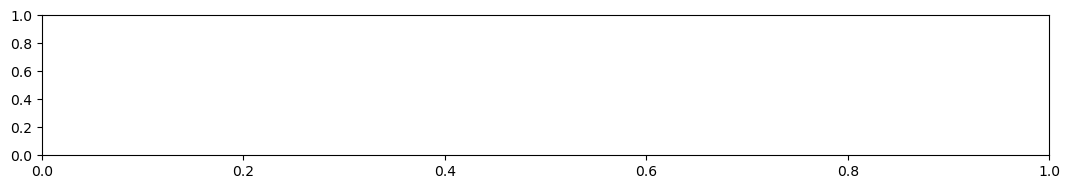

In [ ]:
plt.figure(figsize=(13,10))
plt.subplots_adjust(hspace = 0.5)
plt.subplot(4,1,1)
stats['y_max'].plot(label='Training data',  color = 'black', linewidth = 1.2)
stats['mesh_max'].plot(label='Prediction', color = 'orange', linewidth = 1)
plt.title('Train versus predicted maximum values')
plt.ylabel('Field value')
plt.legend(loc =3,  fontsize=9)

plt.subplot(4,1,2)
plt.plot(np.arange(len(stats['y_min'].values)), stats['y_min'].values, label='Training data',  color = 'black', linewidth = 1.2)
plt.plot(np.arange(len(stats['mesh_min'].values)), stats['mesh_min'].values, label='Prediction', color = 'orange', linewidth = 1)
plt.title('Train versus predicted minumum values')
plt.ylabel('Field value')
plt.legend(loc =3,  fontsize=9)